## Lab 1: Part C -- two real world examples of the use of regularized regression

### Devika Subramanian,  ML Bootcamp, (c) 2019.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils.validation import check_random_state

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn import neighbors

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Face completion: comparing unregularized and ridge regression (L2)

In [2]:
# An interesting problem to understand L2 vs OLS regression
# Face completion

# Load the faces datasets
data = fetch_olivetti_faces()
targets = data.target

data = data.images.reshape((len(data.images), -1))
train = data[targets < 30]
test = data[targets >= 30]  # Test on independent people

# Test on a subset of people
n_faces = 5
rng = check_random_state(4)
face_ids = rng.randint(test.shape[0], size=(n_faces, ))
test = test[face_ids, :]

n_pixels = data.shape[1]
X_train = train[:, :int(np.ceil(0.5 * n_pixels))]  # Upper half of the faces
y_train = train[:, int(np.floor(0.5 * n_pixels)):]  # Lower half of the faces
X_test = test[:, :int(np.ceil(0.5 * n_pixels))]
y_test = test[:, int(np.floor(0.5 * n_pixels)):]

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\OD\scikit_learn_data


In [3]:
# Fit estimators
ESTIMATORS = {
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(alphas=[0.1,1.0,10.])
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, y_train)
    y_test_predict[name] = estimator.predict(X_test)

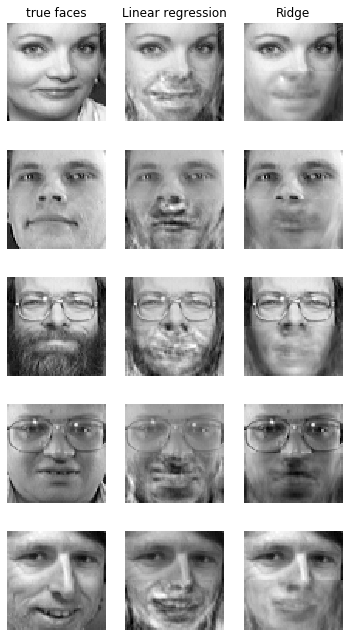

In [4]:
# Plot the completed faces
image_shape = (64, 64)

n_cols = 1 + len(ESTIMATORS)
plt.figure(figsize=(2. * n_cols, 2.26 * n_faces))
plt.title("Face completion with multi-output estimators", size=16)

for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1,
                          title="true faces")


    sub.axis("off")
    sub.imshow(true_face.reshape(image_shape),
               cmap=plt.cm.gray,
               interpolation="nearest")

    for j, est in enumerate(sorted(ESTIMATORS)):
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j,
                              title=est)

        sub.axis("off")
        sub.imshow(completed_face.reshape(image_shape),
                   cmap=plt.cm.gray,
                   interpolation="nearest")

## Compressive sensing: tomography reconstruction with L1 prior (Lasso)
This example shows the reconstruction of an image from a set of parallel projections, acquired along different angles. Such a dataset is acquired in computed tomography (CT).
Without any prior information on the sample, the number of projections required to reconstruct the image is of the order of the linear size l of the image (in pixels). For simplicity we consider here a sparse image, where only pixels on the boundary of objects have a non-zero value. Such data could correspond for example to a cellular material. Note however that most images are sparse in a different basis, such as the Haar wavelets. Only l/7 projections are acquired, therefore it is necessary to use prior information available on the sample (its sparsity): this is an example of compressive sensing.
The tomography projection operation is a linear transformation. In addition to the data-fidelity term corresponding to a linear regression, we penalize the L1 norm of the image to account for its sparsity. The resulting optimization problem is called the Lasso. We use the class sklearn.linear_model.Lasso, that uses the coordinate descent algorithm. Importantly, this implementation is more computationally efficient on a sparse matrix, than the projection operator used here.
The reconstruction with L1 penalization gives a result with zero error (all pixels are successfully labeled with 0 or 1), even if noise was added to the projections. In comparison, an L2 penalization (sklearn.linear_model.Ridge) produces a large number of labeling errors for the pixels. Important artifacts are observed on the reconstructed image, contrary to the L1 penalization. Note in particular the circular artifact separating the pixels in the corners, that have contributed to fewer projections than the central disk.

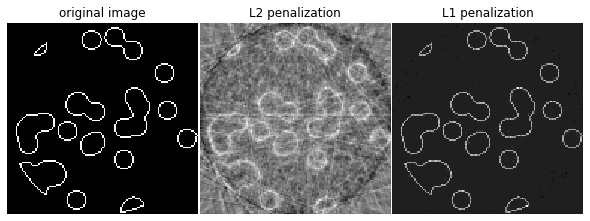

In [5]:
# Author: Emmanuelle Gouillart <emmanuelle.gouillart@nsup.org>
# License: BSD 3 clause

import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt


def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx).astype(np.int64)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y


def build_projection_operator(l_x, n_dir):
    """ Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x ** 2)
    data_unravel_indices = np.hstack((data_unravel_indices,
                                      data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator

def generate_synthetic_data():
    """ Synthetic binary data """
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.) ** 2 + (y - l / 2.) ** 2 < (l / 2.) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))


# Generate synthetic images, and projections
l = 128
proj_operator = build_projection_operator(l, l//7)
data = generate_synthetic_data()
proj = proj_operator * data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determined using cross validation
# with LassoCV
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('original image')
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L2 penalization')
plt.axis('off')
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L1 penalization')
plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)

plt.show()